In [39]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import scale
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xg
from sklearn.inspection import permutation_importance


# Winter Resort Visitation Prediction - Resort 1

*Capstone Data Science Project / Flatiron Data Science Bootcamp*

By: [Lenore Perconti](https://github.com/lperconti)

## Overview

In this project I look at three winter resorts and utilize weather and event data to predict visitation for each resort. This notebook looks at Resort 1. 

### The Stakeholder / Business Problem

For a full, detailed stakeholder and business problem introduction, see the [Read.Me](https://github.com/lperconti/Visitation/blob/main/README.md) file. 

# Exploratory Data Analysis

### Resort 1 Background: 

**Resort 1** is close to a large metropolitan area (approx 455,000 people). The resort's lift capacity is 9,980 riders/hour. 

The resort generously gave four seasons' worth of daily visit totals in an excel document for use in this project. Data was given on the condition that the specific resort not be identified publically. Therefore the name and any location-based information associated with this dataset are withheld from this repository. The daily visits in the given data were further broken down into season pass holder visits, day ticket visits, day visits, and night vists. 

A couple notes on getting the data for this particular ski area: 

* `is_school_out` indicates if the public school district did not have class on a day that normally would have school (weekday). These included Winter Break, MLK Day, Presidents' Day, and Spring Break. Weekends (Sundays and Mondays) surrounding school closures such as Thanksgiving, Presidents Day, were not counted as a `SCHOOL_OUT` day. I was able to source these dates from the local school district's website. There could be other schools in the surrounding area such as colleges, private schools with school out days that this data does not capture. 

* `is_holiday` indicates if the date is a federally (USA) recognized holiday. Examples include: Thanksgiving, Christams Eve, Christmas Day, New Years Eve, New Years Day, MLK Day, and Presidents' Day. 

* Mountain Weather Data was gathered from a NOAA weather station on the mountain where the resort is located.

* Town weather Data was gathered from the metropolitan area's airport. 

#### Data Type Keys - Weather

All weather measurements are in Standard (degrees fahrenheit, inches)

- TMAX - Maximum temperature
- WESD - Water equivalent of snow on the ground
- TAVG - Average Temperature.
- TMIN - Minimum temperature
- PRCP - Precipitation
- TOBS - Temperature at the time of observation
- SNWD - Snow depth
- AWND - Average wind speed
- PRCP - Total Daily Precipitation
- SNOW - Total Daily Snow
- WSF2 - Fastest 2-minute wind speed (mph)
- WSF5 - Fastest 5-minute wind speed (mph)

- T - 'Town'
- M - 'Mountain'

#### After cleaning Visitation stats: 

**Daily Visits:**

count     484.000000

mean     2421.783058

std      1709.932584

min        48.00000

25%      1037.500000

50%      2015.500000

75%      3503.500000

max      7144.000000

In [ ]:
#imports

#libraries for data manipulation and visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#libraries for modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import scale
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xg

#libraries for evaluation
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

In [40]:
#initial look at the dataset
df_1 = pd.read_csv('Data/Resort_1.csv', thousands=',')
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567 entries, 0 to 566
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Date                 567 non-null    object 
 1   Day of week          567 non-null    object 
 2   is_school_out        567 non-null    int64  
 3   is_holiday           567 non-null    int64  
 4   Day Tickets          567 non-null    int64  
 5   Night Ticket         534 non-null    float64
 6   Total Ticket         567 non-null    int64  
 7   SP Day               428 non-null    float64
 8   SP Night             403 non-null    float64
 9   Total SP             567 non-null    float64
 10  Total VIsits Alpine  567 non-null    float64
 11  T - AWND             567 non-null    float64
 12  T - PRCP             567 non-null    float64
 13  T - SNOW             567 non-null    float64
 14  T - SNWD             567 non-null    float64
 15  T - TAVG             567 non-null    int

In [41]:
#See if there's any duplicates: 
df_1.duplicated().value_counts()

False    567
dtype: int64

To get day of week and month categories, we will need to make the `Date` column a datetime object. Day of week and month categories will be used in our models to see if they have any predictive power.

In [42]:
#Date dealings - make the 'Date' column a datetime object, create day of week and month category to do some EDA and use as variables
#make the 'Date' Column a datetime type
df_1['Date'] = pd.to_datetime(df_1['Date'])

#The day_of_week_num column created with Monday=0, Sunday=6. Weekends = 5 & 6, Friday = 4
df_1['day_of_week_num'] = df_1['Date'].dt.dayofweek

#creating Month Column: 1 = January, 2 = February, ect.
df_1['month'] = df_1['Date'].dt.month

#no need for day of week column in a string type anymore
df_1.drop(['Day of week'], axis=1, inplace = True)

df_1['month'].value_counts()

3     124
1     124
12    119
2     113
4      50
11     37
Name: month, dtype: int64

In [43]:
#visiualize date category results: 
df_1.describe()

,is_school_out,is_holiday,Day Tickets,Night Ticket,Total Ticket,SP Day,SP Night,Total SP,Total VIsits Alpine,T - AWND,...,T - WSF5,M_PRCP,M_SNWD,M_TAVG,M_TMAX,M_TMIN,M_TOBS,M_WESD,day_of_week_num,month
count,567.000000,567.000000,567.000000,534.000000,567.000000,428.000000,403.000000,567.000000,567.000000,567.000000,...,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000
mean,0.165785,0.044092,385.682540,158.926966,535.359788,1331.829439,399.446650,1531.911817,2067.271605,7.486543,...,24.092945,0.136861,44.700176,30.261023,36.954145,23.684303,28.620811,13.992769,3.028219,4.862434
std,0.372216,0.205480,391.935468,162.385131,519.033824,1121.998633,376.617499,1342.187125,1797.017090,3.493179,...,8.445873,0.224944,23.450912,7.074986,7.965341,7.649856,7.730381,8.535443,1.998033,4.347793
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.120000,...,8.900000,0.000000,0.000000,5.000000,17.000000,-8.000000,2.000000,0.000000,0.000000,1.000000
25%,0.000000,0.000000,104.500000,0.000000,120.000000,549.750000,0.000000,461.000000,636.000000,4.920000,...,18.100000,0.000000,25.000000,25.000000,31.000000,18.500000,24.000000,7.000000,1.000000,2.000000
50%,0.000000,0.000000,241.000000,116.000000,371.000000,986.500000,347.000000,1212.000000,1641.000000,6.710000,...,23.000000,0.000000,47.000000,30.000000,36.000000,24.000000,29.000000,13.700000,3.000000,3.000000
75%,0.000000,0.000000,598.500000,265.250000,836.500000,2071.750000,606.000000,2348.500000,3187.500000,9.620000,...,30.000000,0.200000,60.000000,35.000000,42.000000,29.000000,34.000000,20.600000,5.000000,11.000000
max,1.000000,1.000000,1884.000000,790.000000,2277.000000,4792.000000,1668.000000,5461.000000,7144.000000,20.800000,...,61.100000,1.100000,95.000000,50.000000,61.000000,42.000000,49.000000,33.000000,6.000000,12.000000


In [44]:
#renaming `Total VIsits Alpine` into something more succinct:
df_1.rename(columns = {'Total VIsits Alpine':'TOTAL_VISITS'}, inplace = True)

Next we want to look at how many Null Values are in our dataset. Null Values may result in errors when modeling, and we will need to decide how to deal with missing data: 

In [45]:
df_1.isnull().sum()

Date                 0
is_school_out        0
is_holiday           0
Day Tickets          0
Night Ticket        33
Total Ticket         0
SP Day             139
SP Night           164
Total SP             0
TOTAL_VISITS         0
T - AWND             0
T - PRCP             0
T - SNOW             0
T - SNWD             0
T - TAVG             0
T - TMAX             0
T - TMIN             0
T - WSF2             0
T - WSF5             0
M_PRCP               0
M_SNWD               0
M_TAVG               0
M_TMAX               0
M_TMIN               0
M_TOBS               0
M_WESD               0
day_of_week_num      0
month                0
dtype: int64

It appears the missing values are in `Night Ticket`, `SP Day`, and `SP Night`, which are all visitation targets. We will likely drop these columns and focus on only prediciting `TOTAL_VISITS` for now. 

# Correlation Matrix 
Let's start exploring correlation, taking out `TOTAL_VISITS` (our target), SP, Day and Night related ticket totals to see if any of our variables are highly correlated. Also taking out `Date` as the specific date is not a predictor. 


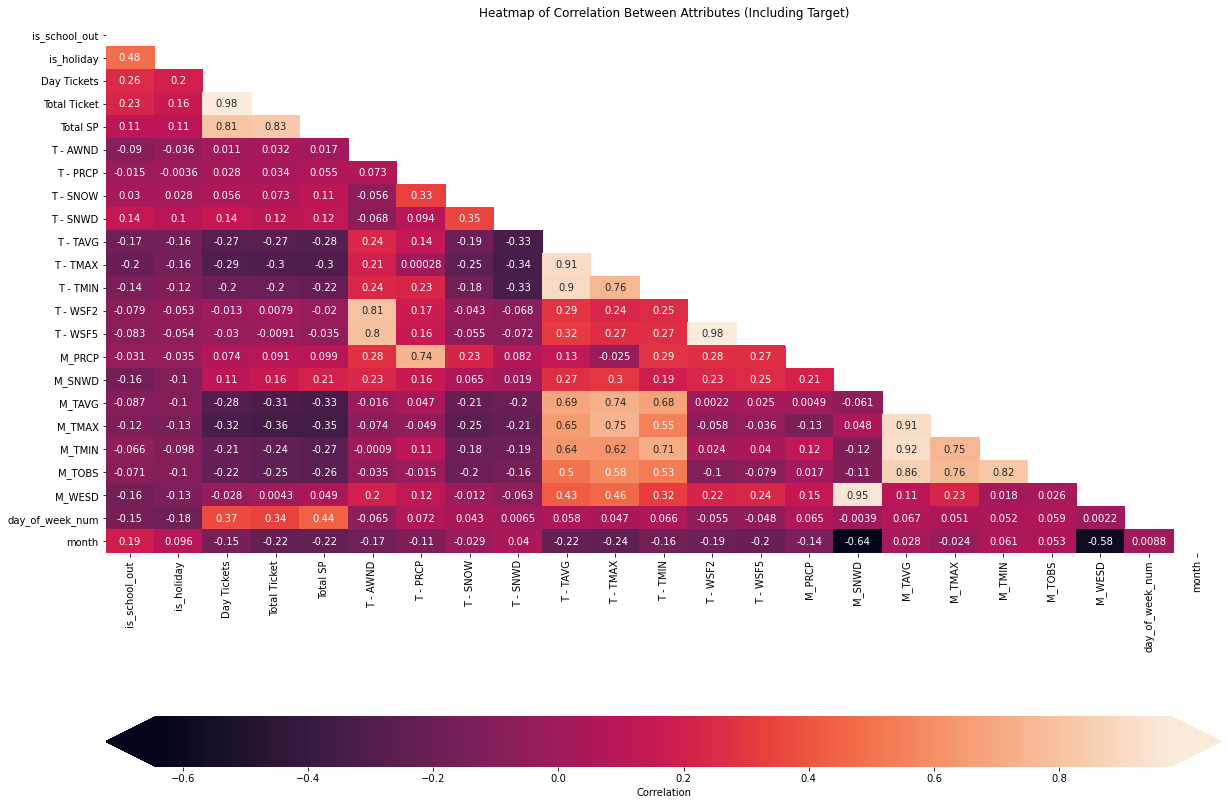

In [46]:

#removing predictor (visit) and date columns for correlation testing
df_1_corr = df_1.drop(columns=['Date', 'TOTAL_VISITS', 'SP Day', 'SP Night', 'Night Ticket'])

# Create a df with the target as the first column,
# then compute the correlation matrix
heatmap_data = df_1_corr
corr = heatmap_data.corr()

# Set up figure and axes
fig, ax = plt.subplots(figsize=(20, 15))

# Plot a heatmap of the correlation matrix, with both
# numbers and colors indicating the correlations
sns.heatmap(data=corr, mask=np.triu(np.ones_like(corr, dtype=bool)), ax=ax, annot=True, 
            cbar_kws={"label": "Correlation", "orientation": "horizontal", "pad": .2, "extend": "both"})

ax.set_title("Heatmap of Correlation Between Attributes (Including Target)");

In [47]:
#identifying the highest correlated variables, correlation >.75

df = df_1_corr.corr().abs().stack().reset_index().sort_values(0, ascending=False)
df['pairs'] = list(zip(df.level_0, df.level_1))
df.set_index(['pairs'], inplace = True)
df.drop(columns=['level_1', 'level_0'], inplace = True)

# cc for correlation coefficient
df.columns = ['cc']
df.drop_duplicates(inplace=True)
df[(df.cc>.75) & (df.cc<1)]


,cc
pairs,
"(T - WSF5, T - WSF2)",0.978815
"(Total Ticket, Day Tickets)",0.975263
"(M_WESD, M_SNWD)",0.953119
"(M_TMIN, M_TAVG)",0.924962
"(M_TMAX, M_TAVG)",0.912155
"(T - TMAX, T - TAVG)",0.911270
"(T - TAVG, T - TMIN)",0.902078
"(M_TAVG, M_TOBS)",0.861747
"(Total SP, Total Ticket)",0.831425


### Multicollinairity decision

Based on the information above it makes sense to drop some data, especially the weather data: 

**Weather:** 

- `T_WSF5` (fastest 5 min wind speed in the metropolotan(town) area)
- `M_WESD` (water equivalent snow on the ground on the mountain)
- `M_TMIN` + `T_TMIN` (temperature min on the mountain and in town)
- `M_TMAX` + `T_TMAX` (temperature max on the mountain and in town)
- `T_TOBS` + `M_TOBS` (temperature at time of observation on mtn and in town)
- `T_WSF2` (fastest 2 min wind speend, keeping the average wind speed for town)

**Ticketing:**

To keep things simple I think for now I am going to remove the ticketing and visit informatoin that breaks down season pass vs ticket and night vs day ticketing. I may want to use these as a prediction if there's time or the business need becomes obvious. Unfortunately I don't have pre-sale data to work with. 

- `SP Night`
- `SP Day`
- `Day Tickets`
- `Night Ticket`
- `Total Tickets`
- `Total SP`

In [48]:
df_1_preprocessed = df_1.drop(columns=['T - WSF5', 'M_WESD', 'M_TMIN', 'T - TMIN', 'M_TMAX', 'T - TMAX', 'M_TOBS', 'T - WSF2', 'SP Night', 'SP Day', 'Day Tickets', 'Night Ticket', 'Total Ticket', 'Total SP'])
df_1_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567 entries, 0 to 566
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             567 non-null    datetime64[ns]
 1   is_school_out    567 non-null    int64         
 2   is_holiday       567 non-null    int64         
 3   TOTAL_VISITS     567 non-null    float64       
 4   T - AWND         567 non-null    float64       
 5   T - PRCP         567 non-null    float64       
 6   T - SNOW         567 non-null    float64       
 7   T - SNWD         567 non-null    float64       
 8   T - TAVG         567 non-null    int64         
 9   M_PRCP           567 non-null    float64       
 10  M_SNWD           567 non-null    int64         
 11  M_TAVG           567 non-null    int64         
 12  day_of_week_num  567 non-null    int64         
 13  month            567 non-null    int64         
dtypes: datetime64[ns](1), float64(6), int64(7)

## 0 visit days
Taking a look at rows with 0 visits (these are the days the resort is closed)

In [49]:
df_1_preprocessed[df_1_preprocessed.TOTAL_VISITS == 0]

,Date,is_school_out,is_holiday,TOTAL_VISITS,T - AWND,T - PRCP,T - SNOW,T - SNWD,T - TAVG,M_PRCP,M_SNWD,M_TAVG,day_of_week_num,month
0,2017-11-21,1,0,0.0,7.61,0.05,0.0,0.0,49,0.2,7,43,1,11
1,2017-11-22,1,0,0.0,4.47,0.01,0.0,0.0,55,0.1,6,47,2,11
2,2017-11-23,1,1,0.0,7.16,0.01,0.0,0.0,53,0.1,4,49,3,11
3,2017-11-24,1,0,0.0,6.49,0.26,0.0,0.0,53,0.1,4,35,4,11
4,2017-11-25,0,0,0.0,7.38,0.00,0.0,0.0,43,0.2,3,41,5,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
560,2021-04-12,0,0,0.0,3.80,0.00,0.0,0.0,41,0.0,45,32,0,4
561,2021-04-13,0,0,0.0,6.71,0.00,0.0,0.0,47,0.0,43,36,1,4
562,2021-04-14,0,0,0.0,6.93,0.00,0.0,0.0,48,0.0,42,35,2,4
563,2021-04-15,0,0,0.0,8.28,0.00,0.0,0.0,50,0.0,41,38,3,4


In [50]:
#dropping the 0 visit days: 
df_1_preprocessed = df_1_preprocessed[df_1_preprocessed.TOTAL_VISITS != 0]
df_1_preprocessed['TOTAL_VISITS'].value_counts()

2203.0    3
978.0     3
715.0     2
1355.0    2
879.0     2
         ..
883.0     1
7144.0    1
5748.0    1
895.0     1
432.0     1
Name: TOTAL_VISITS, Length: 464, dtype: int64

In [51]:
#seeing what's left: 
df_1_preprocessed['TOTAL_VISITS'].describe()

count     484.000000
mean     2421.783058
std      1709.932584
min        48.000000
25%      1037.500000
50%      2015.500000
75%      3503.500000
max      7144.000000
Name: TOTAL_VISITS, dtype: float64

## Indexing with Date

In [52]:
#df_1_preprocessed.reset_index(inplace=True)
df_1_preprocessed.set_index('Date', inplace=True)
df_1_preprocessed.head(2)

,is_school_out,is_holiday,TOTAL_VISITS,T - AWND,T - PRCP,T - SNOW,T - SNWD,T - TAVG,M_PRCP,M_SNWD,M_TAVG,day_of_week_num,month
Date,,,,,,,,,,,,,
2017-12-21,0,0,432.0,10.07,0.00,0.0,0.0,29,0.0,15,21,3,12
2017-12-22,1,0,48.0,4.47,0.14,4.0,0.0,32,0.3,19,24,4,12


# Visualizations

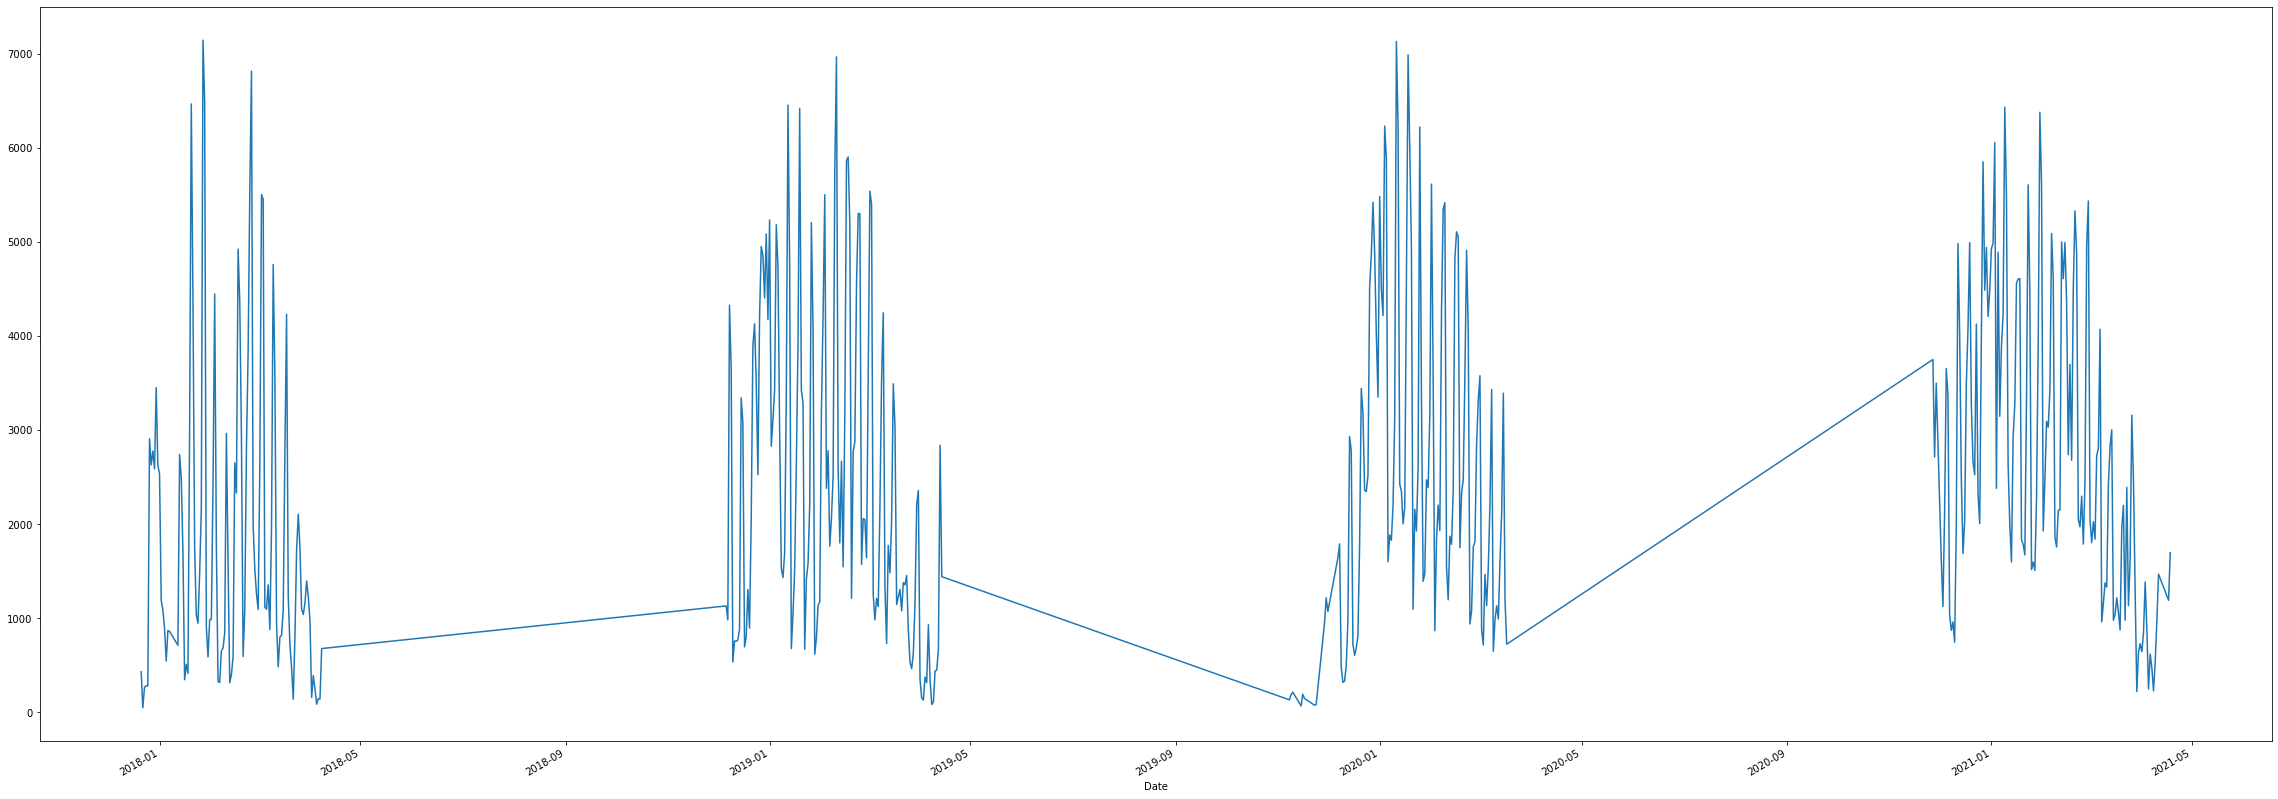

In [53]:
#visualizing the visitations over time
df_1_preprocessed['TOTAL_VISITS'].plot(figsize = (40, 15));

Visualizations: Boxplot

This basic Boxplots, or sometimes called a box-and-whisker plot, is helpful to visualize distributions of our visitation data. The box shows the quartiles of the data and whiskers extend to show the rest of the distribution. It's helpful to see how the data is distributed. 

month
1     2482.5
2     2602.0
3     1221.5
4      247.5
11       0.0
12    1687.0
Name: TOTAL_VISITS, dtype: float64
month
1     2571.0
2     2602.0
3     1337.0
4      449.0
11     193.0
12    2525.0
Name: TOTAL_VISITS, dtype: float64


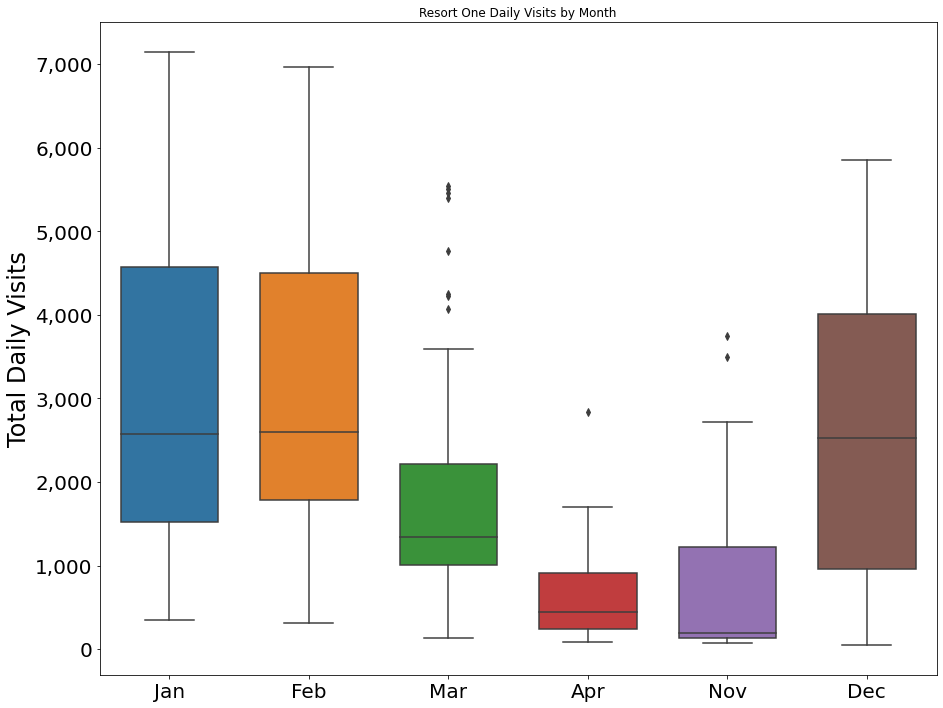

In [54]:
#visualizing daily visits by month: 
medians = df_1.groupby(['month'])['TOTAL_VISITS'].median()
print(medians)

import matplotlib as mpl

fig, ax = plt.subplots(figsize=(15, 12))
sns.boxplot(x='month', y='TOTAL_VISITS', data=df_1_preprocessed, width=.7)

medians = df_1_preprocessed.groupby(['month'])['TOTAL_VISITS'].median()
print(medians)

ax.set_xlabel("")

ax.set_ylabel("Total Daily Visits", fontsize=24)

ax.set_title("Resort One Daily Visits by Month")

plt.yticks(fontsize=20)

plt.xticks([0, 1, 2, 3, 4, 5], ['Jan', 'Feb', 'Mar', 'Apr', 'Nov', 'Dec'], fontsize=20)

ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

plt.savefig('Visuals/resort1visits.png', dpi=300);

Let's look at the relationship between visitors and Precipitation on the Mountain: 

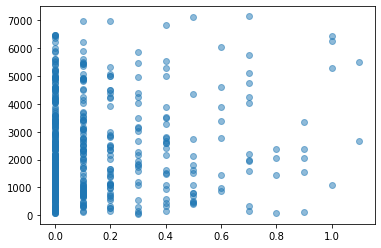

In [55]:
fig, ax = plt.subplots()

ax.scatter(df_1_preprocessed['M_PRCP'], df_1_preprocessed["TOTAL_VISITS"], alpha=0.5)

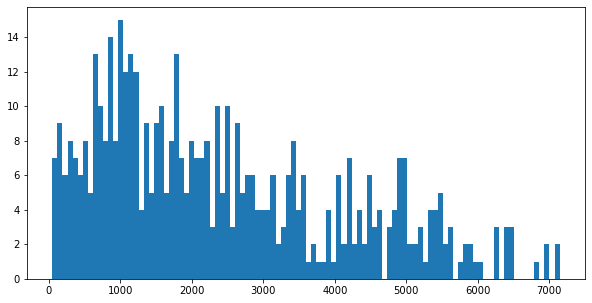

In [56]:
#visualization of target - Visits
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(df_1_preprocessed['TOTAL_VISITS'], bins=100);

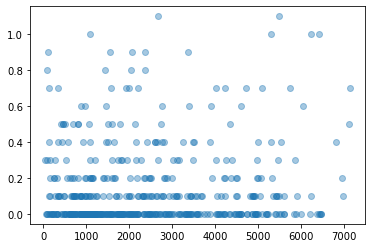

In [57]:
#Relationship between mountain precipitation and visitation
plt.scatter(y=df_1_preprocessed['M_PRCP'], x=df_1_preprocessed['TOTAL_VISITS'], alpha=.4)
plt.savefig('Visuals/resort1precip.png', dpi=300);

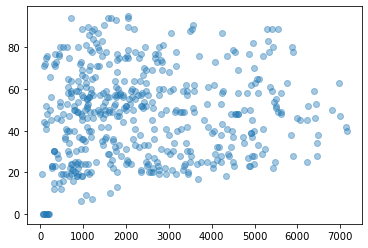

In [58]:
#relationship between snowdepth and visitation
plt.scatter(y=df_1_preprocessed['M_SNWD'], x=df_1_preprocessed['TOTAL_VISITS'], alpha=.4)
plt.savefig('Visuals/resort1msnowdepth.png', dpi=300);

At first glance, calendar events seem to have more impact on visitation: 

is_holiday
0    2373.318872
1    3393.173913
Name: TOTAL_VISITS, dtype: float64
is_school_out
0    2287.069479
1    3092.024691
Name: TOTAL_VISITS, dtype: float64


<AxesSubplot:xlabel='M_PRCP', ylabel='TOTAL_VISITS'>

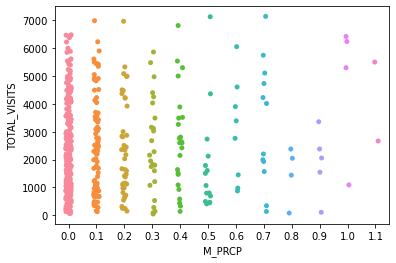

In [59]:
Holiday_averages=df_1_preprocessed.groupby(df_1_preprocessed['is_holiday'])['TOTAL_VISITS'].mean()
print(Holiday_averages)

Schoolout_averages=df_1_preprocessed.groupby(df_1_preprocessed['is_school_out'])['TOTAL_VISITS'].mean()
print(Schoolout_averages)

fig, ax = plt.subplots()
sns.stripplot(x='M_PRCP', y='TOTAL_VISITS', data=df_1_preprocessed)

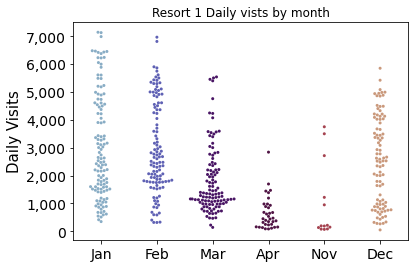

In [60]:
fig, ax = plt.subplots()
sns.swarmplot(x='month', y='TOTAL_VISITS', data=df_1_preprocessed, size=3, palette='twilight', edgecolor='none')

ax.set_xlabel("")
ax.set_title("Resort 1 Daily vists by month")
ax.set_ylabel("Daily Visits", fontsize=15)
plt.yticks(fontsize=14)
plt.xticks([0, 1, 2, 3, 4, 5], ['Jan', 'Feb', 'Mar', 'Apr', 'Nov', 'Dec'], fontsize=14)

ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.savefig('Visuals/resort1swarmplotmonth.png', dpi=300);

### Saving Cleaned Resort 3 Data to CSV for reference: 

In [61]:
df_1_preprocessed.to_csv("Data/DF_1_clean.csv")

# First Simple Model
**Linear Regression**

We will be using a regression analysis to estimate the relationships between the dependent (Visits) and independent variables in our dataset. A simple Linear Regression model makes sense to build ourbaseline model with. The R-squared score tells us how much of the total variability in the data is explained by the model and is very useful when comparing different models. This will help us establish and determine if there is a realationship between our independent variables and the visitation this ski resort experiences. We can also use regression analysis to determine which specific features are good predictors for the target and which are not. 

Regression analysis is fairly interpretable, and being able to explain these models to a non-technical audience at ski resorts wil be key to the models being used for prediction. 

The final reason for using Regression Analysis is the ability to generate predictions, which is what this analysis is all about: seeing if we can predict visitation for ski resorts. 

To set up modeling, we will first split our data into X (independent) and Y(dependent) dataframes. Then we will split the data into train and test splits. Since we are working with a fairly small dataset, we will be using cross validation on our training data to score the models without having to utlize the test data until a best model has been determined. 



In [62]:
#Split into test and train X and Y
X = df_1_preprocessed.drop(columns=['TOTAL_VISITS'])
y = df_1_preprocessed['TOTAL_VISITS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [63]:
#visualizing our X to ensure the dataframe split correctly
X.head()

,is_school_out,is_holiday,T - AWND,T - PRCP,T - SNOW,T - SNWD,T - TAVG,M_PRCP,M_SNWD,M_TAVG,day_of_week_num,month
Date,,,,,,,,,,,,
2017-12-21,0,0,10.07,0.00,0.0,0.0,29,0.0,15,21,3,12
2017-12-22,1,0,4.47,0.14,4.0,0.0,32,0.3,19,24,4,12
2017-12-23,1,0,6.93,0.14,2.1,5.1,32,0.0,23,18,5,12
2017-12-24,1,1,4.70,0.13,1.8,3.9,17,0.3,23,19,6,12
2017-12-25,1,1,3.36,0.09,1.0,5.9,22,0.1,22,26,0,12


In [78]:
# creating categorical lists and Transformer: 
cat = ['is_school_out', 'is_holiday', 'day_of_week_num', 'month']
non_cat = ['T - AWND', 'T - PRCP', 'T - SNOW', 'T - SNWD', 'T - TAVG', 'M_PRCP', 'M_SNWD', 'M_TAVG']

Transformer = ColumnTransformer([
	('ohe', OneHotEncoder(), cat),
	('scaler', StandardScaler(), non_cat),
	], remainder ='passthrough')

# Baseline Linear Regression model 
with One Hot Encoding and Standard Scaler in a pipeline

In [65]:

#setting up the pipe and training the model: 

LRPipe = Pipeline([('trans', Transformer),
                ('linreg', LinearRegression())])

LRPipe.fit(X_train, y_train)

#cross validation and scoring
cv_LR = cross_validate(LRPipe, X_train, y_train, return_train_score=True, cv=5)
cv_score_LR = cross_val_score(LRPipe, X_train, y_train, cv = 5)

print(f'Cross Validation Scores, Linear Regression: {cv_LR}')

print(f'mean CV Score, Linear Regression, Resort 3: {cv_score_LR.mean()}')

Cross Validation Scores, Linear Regression: {'fit_time': array([0.04224586, 0.03379774, 0.04090691, 0.01570988, 0.01338315]), 'score_time': array([0.0224452 , 0.032547  , 0.008744  , 0.00675607, 0.00983882]), 'test_score': array([0.47984437, 0.53637444, 0.73232436, 0.66131302, 0.48757651]), 'train_score': array([0.68906124, 0.67728235, 0.63319602, 0.64723468, 0.68273521])}
mean CV Score, Linear Regression, Resort 3: 0.5794865402447538


With Encoding and scaling, the Basic Linear Regression CV score is 0.579

There is definitly some room for improvement, but we're doing OK so far.

## Tree Regressor

why tree next?

In [83]:
Transformer = ColumnTransformer([
	('ohe', OneHotEncoder(), cat),
	# ('scaler', StandardScaler(), non_cat), #no need to scale on Trees
	], remainder ='passthrough')

#Pipeline second Step: treeregressor
dt_clf2 = DecisionTreeRegressor(random_state = 42)

#pipeline
pipeline_dt = Pipeline([('transformer', Transformer),
						('dtr', dt_clf2)])

#set up grid search paramater grid
dt_param_grid = {
    'dtr__min_samples_split': [2, 4, 6, 8],
    'dtr__max_depth': [None, 2, 3, 4, 5, 6],
	'dtr__splitter': ['random', 'best']
}

#set up gridsearch:
gridsearch_dt = GridSearchCV(estimator=pipeline_dt,
						  param_grid=dt_param_grid,
						  cv=5)

#fit gridsearch
gridsearch_dt.fit(X_train, y_train)

print("Best Parameter Combination for Tree Regressor Found During Grid Search:")
print(gridsearch_dt.best_params_)

Best Parameter Combination for Tree Regressor Found During Grid Search:
{'dtr__max_depth': 5, 'dtr__min_samples_split': 4, 'dtr__splitter': 'best'}


In [84]:
Transformer = ColumnTransformer([
	('ohe', OneHotEncoder(), cat),
	# ('scaler', StandardScaler(), non_cat), #no need to scale on Trees
	], remainder ='passthrough')

#Pipeline second Step: treeregressor
dt_clf3 = DecisionTreeRegressor(max_depth=5, min_samples_split=4, splitter='best', random_state = 42)

#pipeline
pipeline_dt_best = Pipeline([('transformer', Transformer),
						('dtr', dt_clf3)])


pipeline_dt_best.fit(X_train, y_train)

cv = cross_validate(pipeline_dt_best, X_train, y_train, return_train_score=True, cv=5)
cv_score = cross_val_score(pipeline_dt_best, X_train, y_train, cv = 5)
print(f'Cross Validation Scores bDecision treeest Decision Tree Regressor: {cv}')

print(f'mean CV Score: {cv_score.mean()}')

Cross Validation Scores bDecision treeest Decision Tree Regressor: {'fit_time': array([0.03358006, 0.02057004, 0.02237988, 0.01736331, 0.02448511]), 'score_time': array([0.00809598, 0.00996399, 0.01013017, 0.02309561, 0.01484895]), 'test_score': array([0.44124527, 0.54965897, 0.45015904, 0.688071  , 0.41617338]), 'train_score': array([0.73431034, 0.76736684, 0.7726827 , 0.7539595 , 0.7848853 ])}
mean CV Score: 0.509061532768853


Decision Tree model with optomized hyperparamaters performed worse than Linear Regression (LR Mean CV score = .579) at a mean CV score of 0.509.

## Trying Random Forests:

Our next model will be Random Forests. While Random Forests tend to take more time to run, they tend to do well with 'weak learners', which we may have here. Random forests combine several decision trees which individually are weak performers and combine them together for a stronger learner. 

In [68]:


Transformer = ColumnTransformer([
	('ohe', OneHotEncoder(), cat),
	# ('scaler', StandardScaler(), non_cat), #no need to scale on Trees
	], remainder ='passthrough')

#Pipeline second Step: treeregressor
rfr = RandomForestRegressor(random_state = 42)

#pipeline
pipeline_rfr = Pipeline([('transformer', Transformer),
						('dtr', rfr)])

#set up grid search paramater grid
rfr_param_grid = {
    'dtr__n_estimators': [2, 4, 6, 8, 10, 12, 14, 16],
    'dtr__max_depth': [None, 2, 3, 4, 5, 6, 8, 10],
	'dtr__max_features': ['auto', 'sqrt', 'log2'],
	'dtr__criterion': ['mse', 'mae']
}

#set up gridsearch:
gridsearch_rfr = GridSearchCV(estimator=pipeline_rfr,
						  param_grid=rfr_param_grid,
						  cv=5)

#fit gridsearch
gridsearch_rfr.fit(X_train, y_train)

print("Best Parameter Combination Found During Grid Search:")
print(gridsearch_rfr.best_params_)


Best Parameter Combination Found During Grid Search:
{'dtr__criterion': 'mse', 'dtr__max_depth': None, 'dtr__max_features': 'sqrt', 'dtr__n_estimators': 10}


In [69]:
#modeling with best paramaters found in Grid Search: 
Transformer = ColumnTransformer([
	('ohe', OneHotEncoder(), cat),
	# ('scaler', StandardScaler(), non_cat), #no need to scale on Trees
	], remainder ='passthrough')

#Pipeline second Step: treeregressor
rfr_best = RandomForestRegressor(criterion = 'mse', max_depth = None, max_features = 'sqrt', n_estimators = 10, random_state = 42)

#pipeline
pipeline_rfr_best = Pipeline([('transformer', Transformer),
						('dtr', rfr_best)])


pipeline_rfr_best.fit(X_train, y_train)

cv = cross_validate(pipeline_rfr_best, X_train, y_train, return_train_score=True, cv=5)
cv_score = cross_val_score(pipeline_rfr_best, X_train, y_train, cv = 5)
print(f'Cross Validation Scores best Random Forest Regressor: {cv}')

print(f'mean CV Score: {cv_score.mean()}')


Cross Validation Scores best Random Forest Regressor: {'fit_time': array([0.02399516, 0.05153203, 0.03333497, 0.02297592, 0.02309179]), 'score_time': array([0.00611687, 0.00928688, 0.00577426, 0.00757027, 0.0045619 ]), 'test_score': array([0.55986679, 0.67336618, 0.74058046, 0.6732444 , 0.54516542]), 'train_score': array([0.92655425, 0.91821211, 0.9111    , 0.90889369, 0.91310719])}
mean CV Score: 0.6384446490641958


As we can see, the Random Forest Model performed better than the decision Tree. Random Forest regressor mean CV score = .6638, which is an improvement on both the Linear Regression and decision tree Model. 

### Gradient Boosting: 

Gradient boosting is another model that combines weak learners and individual trees to create a stronger learner. Gradient boosting builds one tree at a time, and each new tree helps correct errors made by the previous tree. This is also a computationally expensive model and takes a bit of time to run, and we will have to watch out for overfitting of the model. 

In [70]:
Transformer = ColumnTransformer([
	('ohe', OneHotEncoder(), cat),
	# ('scaler', StandardScaler(), non_cat), #no need to scale on Trees
	], remainder ='passthrough')

GBR = GradientBoostingRegressor(random_state = 42)

pipeline_gbr = Pipeline([('transformer', Transformer),
						('gbr', GBR)])

#set up grid search paramater grid
gbr_param_grid = {
    'gbr__n_estimators': [50, 100, 200, 300],
    'gbr__criterion': ['friedman_mse', 'mse', 'mae'],
	'gbr__min_samples_split': [2, 3, 4, 5]

}

#set up gridsearch:
gridsearch_gbr = GridSearchCV(estimator=pipeline_gbr,
						  param_grid=gbr_param_grid,
						  cv=5)

#fit gridsearch
gridsearch_gbr.fit(X_train, y_train)

print("Best Parameter Combination Found During GBR Grid Search:")
print(gridsearch_gbr.best_params_)


Best Parameter Combination Found During GBR Grid Search:
{'gbr__criterion': 'mse', 'gbr__min_samples_split': 5, 'gbr__n_estimators': 200}


In [71]:
Transformer = ColumnTransformer([
	('ohe', OneHotEncoder(), cat),
	# ('scaler', StandardScaler(), non_cat), #no need to scale on Trees
	], remainder ='passthrough')

GBR_best = GradientBoostingRegressor(criterion='mse', n_estimators=200, min_samples_split= 5, random_state = 42)

#pipeline
pipeline_gbr_best = Pipeline([('transformer', Transformer),
						('gbr', GBR_best)])

pipeline_gbr_best.fit(X_train, y_train)


cv = cross_validate(pipeline_gbr_best, X_train, y_train, return_train_score=True, cv=5)
cv_score = cross_val_score(pipeline_gbr_best, X_train, y_train, cv = 5)
print(f'Cross Validation Score Gradient Boosting Model: {cv}')

print(f'mean CV Score: {cv_score.mean()}')

Cross Validation Score Gradient Boosting Model: {'fit_time': array([0.13171697, 0.12799406, 0.16082287, 0.14935923, 0.14530873]), 'score_time': array([0.00510597, 0.00635886, 0.00764894, 0.00540376, 0.00605416]), 'test_score': array([0.62728481, 0.68505887, 0.6747616 , 0.7939104 , 0.6750317 ]), 'train_score': array([0.96385551, 0.96685321, 0.96533828, 0.95868339, 0.96596248])}
mean CV Score: 0.6912094773793598


So far Gradient Booster Model is performing the best with a mean CV score of .691. we see some overfitting with better train scores than test scores. 

## XGBoost

Finally to try and get even better mean CV scores and model, Let's see if we can improve with X Boost. 

XGBoost is a powerful regressor that works off the assumption that the base learners are bad. it uses the error residuals of the previous model to fit the next model, and the final prediction is a weighted sum of all the tree predictions. This model is good for minimizing variance/overfitting. 


In [85]:
Transformer = ColumnTransformer([
	('ohe', OneHotEncoder(), cat),
	('scaler', StandardScaler(), non_cat),
	], remainder ='passthrough')

xgb_r = xg.XGBRegressor(seed = 123)

#pipeline
xboostPipe = Pipeline([('transformer', Transformer),
						('xgb_r', xgb_r)])

# objective ='reg:squarederror', n_estimators = 10, 
boost_param_grid = {
    'xgb_r__eta': [.2, .3, .4, .5, .6, .7, .8],
	'xgb_r__max_depth': [3, 4, 5, 6, 7, 8, 9, 10]
}

gridsearch_boost = GridSearchCV(estimator=xboostPipe,
						  param_grid=boost_param_grid,
						  cv=5)

#fit gridsearch
gridsearch_boost.fit(X_train, y_train)

print("Best Parameter Combination Found During XBoost Grid Search:")
print(gridsearch_boost.best_params_)

Best Parameter Combination Found During XBoost Grid Search:
{'xgb_r__eta': 0.2, 'xgb_r__max_depth': 3}


In [89]:
Transformer = ColumnTransformer([
	('ohe', OneHotEncoder(), cat),
	# ('scaler', StandardScaler(), non_cat),
	], remainder ='passthrough')

#Pipeline second Step: 
xgb_r_best = xg.XGBRegressor(eta = 0.2, max_depth = 3, seed = 123)

xboost_pipe_best = Pipeline([('transformer', Transformer),
						('xgb_r_2', xgb_r_best)])

xboost_pipe_best.fit(X_train, y_train)

cv = cross_validate(xboost_pipe_best, X_train, y_train, return_train_score=True, cv=5)
cv_score = cross_val_score(xboost_pipe_best, X_train, y_train, cv = 5)
print(f'Cross Validation Scores X Boost: {cv}')

print(f'mean CV Score X Boost: {cv_score.mean()}')

Cross Validation Scores X Boost: {'fit_time': array([0.07625198, 0.04629803, 0.04954314, 0.05134416, 0.04434633]), 'score_time': array([0.00893188, 0.009408  , 0.00683093, 0.00692201, 0.00708604]), 'test_score': array([0.63686313, 0.7072925 , 0.71510326, 0.7883116 , 0.65902666]), 'train_score': array([0.95631625, 0.96415222, 0.96199409, 0.95670808, 0.96122295])}
mean CV Score X Boost: 0.7013194264453662


X boost for resort 1 is preforming slightly better than Gradient Booster Regressor at CV score of .701

# Evaulation

Since XGBoost model performed the best and looks like it's the least overfit, we will evaluate the model on our test data: 

In [90]:
#boost Test Score
xboost_pipe_best.score(X_test, y_test)

0.7783719887607801

XGBoost gets a test CV score of .782, this means we can account for 78% of the variance in the Resort 1 data with our Gradient Booster Regressor model. Let's take a look at our predictions: 

In [91]:
y_pred_xboost = xboost_pipe_best.predict(X_test)

df = pd.DataFrame({'Real Visits Resort 1':y_test, 'Predicted XBoost Visits':y_pred_xboost, 
                    'Difference': abs(y_test - y_pred_xboost)})
print('Mean Difference, predicted - actual')
print(df['Difference'].mean())
df.head()

Mean Difference, predicted - actual
687.8116120013995


,Real Visits Resort 1,Predicted XBoost Visits,Difference
Date,,,
2021-02-07,4612.0,4164.014648,447.985352
2021-04-04,887.0,1871.096924,984.096924
2019-02-20,2769.0,3016.289795,247.289795
2021-03-07,4072.0,3139.466309,932.533691
2020-01-27,1393.0,2205.445312,812.445312


In [92]:
ohe = xboost_pipe_best.named_steps["transformer"].transformers_[0][1].get_feature_names()
numbers = non_cat

columns = [*ohe, *numbers]

for name, importance in zip(columns, xboost_pipe_best['xgb_r_2'].feature_importances_):
    print(name, importance)

x0_0 0.10317365
x0_1 0.0
x1_0 0.023376193
x1_1 0.0
x2_0 0.020765841
x2_1 0.057336442
x2_2 0.0019764253
x2_3 0.0025452178
x2_4 0.0350706
x2_5 0.13947353
x2_6 0.1654163
x3_1 0.0370424
x3_2 0.037307676
x3_3 0.045449104
x3_4 0.040754948
x3_11 0.08848914
x3_12 0.012864601
T - AWND 0.010084906
T - PRCP 0.0097507825
T - SNOW 0.01947744
T - SNWD 0.014582939
T - TAVG 0.059271418
M_PRCP 0.0070099
M_SNWD 0.050687484
M_TAVG 0.018093089


Text(0.5, 1.0, 'Feature Importance')

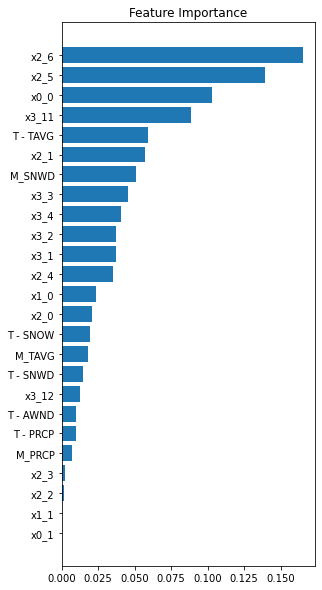

In [97]:
feature_importance = xboost_pipe_best['xgb_r_2'].feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0])
fig = plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(columns)[sorted_idx])
plt.title("Feature Importance")


# Discussion/Conclusions: 

For Resort One, we found that XGBoost Model with hyperparamters of `eta` = 0.2 and `max_depth` = 3 explained 78% of the variance in our data. 

The Feature Importance report shows that in general, Calendar features are more important than weather related features when predicting visitation.

Out of weather related features, Temperature in town and mountain snowdepth are important features. Mountain precipitataion was found to be a weak predictor of visitation. 

### Using the model to predict visitors: 

The Mean difference between predictions and actual is 687.81. That means that on any given day the predictor could be +/- 688 visitors off, or more Considering that the standard deviation of the target is 1709.93, our predictor is well within 1 standard deviation and successful. In reality when the ski resort goes to predict visitors, it may not make busienss sense to completely rely upon this model for staffing and resources. Parking 600 more cars than expected could strain personnel in the parking department, or preparing food for 600 more visitors than what actually came may result in loss of food product. 

This Model by no means was intended to be the sole tool off which to predict visitors. It is intended to help resorts with forecasting a ballpark visitation and then using information that a human element can apply such as: special events occuring, marketing, and long term weather trends. For example, a powder day after a dry spel may draw more visitors than a powder day after two weeks of consistant quality snowfall.

## Future Research
For more in-depth analysis and future research, see the [Read.Me](https://github.com/lperconti/Visitation/blob/main/README.md) file. 
